# Gaussian surface approximation code
Code to loop through all the images for a city and return a data frame of the Gaussian fit parameters and dates

In [98]:
#Manual entries
CITY_COUNTRY = "HUAMBO_ANGOLA"

SATELLITE = 'MOD11A2' #TERRA
#SATELLITE = 'MYD11A2' #AQUA

In [99]:
# Import packages
import os
import re  # regular expressions for getting lat lon grid
import pathlib
import warnings
import gdal
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import rasterio as rio # for extracting subsets
from rasterio.plot import plotting_extent #for plotting
import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es
import earthpy.mask as em
import pandas as pd
import pickle
import matplotlib.patches as mpatches

#for the reprojecting
import pyproj
from pyproj import CRS
from pyproj import Transformer
import cartopy
import cartopy.crs as ccrs
from shapely.geometry import Point, LineString, Polygon
from pyhdf.SD import SD, SDC
import datetime as dt
import scipy
from scipy import interpolate
import geopandas as gpd

#Regression packages (used for linear and polynomial regression)
import operator
from sklearn import linear_model
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

#for root finding and curve fitting
from scipy import optimize
from scipy.optimize import curve_fit

#for converting angles from radians to degrees
import math

warnings.simplefilter('ignore')


#load in csv of city lons and lats
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT'))

CITY_COUNTRY_lat_lon = pd.read_excel('CITY_COUNTRY_lat_lon.xlsx')

#Identify names/ values of chosen city
#set the city latitude and longitudes and city name
City_Lat = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['Lat'].values[0]
City_Lon = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['Lon'].values[0]
City_name = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['City'].values[0]
City_area = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['City_Area'].values[0]
City_bound_xmin = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['City_Bound_xmin'].values[0]/1000
City_bound_xmax = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['City_Bound_xmax'].values[0]/1000
City_bound_ymin = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['City_Bound_ymin'].values[0]/1000
City_bound_ymax = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['City_Bound_ymax'].values[0]/1000

#create satellite name for plots
if SATELLITE == 'MOD11A2':
    satellite_name = 'Terra'
else:
    satellite_name = 'Aqua'
    
#Load in LULC data, these bases were created in JASMIN
with open('UHI_Project_Pickle_Files\LULC_Pickles\LULC_{}.pkl'.format(CITY_COUNTRY), 'rb') as f:
     LULC_df = pickle.load(f)

In [100]:
# Set working directory
#MOD11A2 is terra
#MYD11A2 is aqua

#Set path to chosen satellite
os.chdir(os.path.join('D:\\','MODIS_8_day_LST', CITY_COUNTRY, SATELLITE))

#set path to current directory
path = pathlib.Path().absolute()
            
#Area to look at will be the city centre +/- 0.2 degs?
min_lat = City_Lat - 0.2
max_lat = City_Lat + 0.2
min_lon = City_Lon - 0.2
max_lon = City_Lon + 0.2

#Read pickle files back in from image select code. These will the be looped through
with open('Day_list.pkl', 'rb') as f:
    Day_list = pickle.load(f)
    
with open('Night_list.pkl', 'rb') as f:
    Night_list = pickle.load(f)
    
    
#Create the dataframe, contains the filenames and columns to be filled
parameters_df = pd.DataFrame(data = Day_list, columns = ['Filename'])
parameters_df['Date'] = np.nan
parameters_df['Year'] = np.nan
parameters_df['Month'] = np.nan
parameters_df['day_a0'] = np.nan
parameters_df['day_x0'] = np.nan
parameters_df['day_y0'] = np.nan
parameters_df['day_phi'] = np.nan
parameters_df['day_ax'] = np.nan
parameters_df['day_ay'] = np.nan
parameters_df['day_std_dev_a0'] = np.nan
parameters_df['day_std_dev_x0'] = np.nan
parameters_df['day_std_dev_y0'] = np.nan
parameters_df['day_std_dev_phi'] = np.nan
parameters_df['day_std_dev_ax'] = np.nan
parameters_df['day_std_dev_ay'] = np.nan
parameters_df['method_1_SUHI'] = np.nan
parameters_df['method_2_SUHI'] = np.nan

In [121]:
##DEFINE FUNCTIONS

#Define functions for bit flag interpretation
#bit flag interpretation
#Defining QC functions
#function to check the status of a byte on the QC control
def check_bits(x,n):
    if (x & (1<<n)): 
  ## n-th bit is 1 
        flag = 1
    else:
  ## n-th bit is 0
        flag = 0
    return flag

#function to check bytes 1 and 2 and return 0 if they are both 0
def quality_control(x):
    if ((check_bits(x,1) == 0) and (check_bits(x,2) == 0)):
  ##if bit 1 and bit 2 are 0 then 0 
        flag = 0
    else:
  ##otherwise flag is 1
        flag = 1
    return flag    


#function to extract the subdatasets of interest and return a dataframe 
#QC is still needed as the pixels which are of bad quality will still need to be removed/ masked 

def dataframe_create(file_name):

    #path to the file
    data_path = os.path.join(file_name)
    #LST daytime
    with rio.open(data_path) as dataset:
        # Loop through each subdataset in HDF4 file
        for name in dataset.subdatasets:
        
        # Use regular expression to identify if subdataset has LST:LST in the name
            if re.search("LST:LST_Day_1km*", name):
        
                # Open the band subdataset
                with rio.open(name) as subdataset:
                    modis_meta = subdataset.profile
                
                    # Read band data as a 2 dim arr and append to list
                    LST_day = subdataset.read(1)
                
    #LST night       
    with rio.open(data_path) as dataset:
        # Loop through each subdataset in HDF4 file
        for name in dataset.subdatasets:
        
            # Use regular expression to identify if subdataset has LST:LST in the name
            if re.search("LST:LST_Night_1km*", name):
        
                # Open the band subdataset
                with rio.open(name) as subdataset:
                    modis_meta = subdataset.profile
                
                    # Read band data as a 2 dim arr and append to list
                    LST_night = subdataset.read(1)                
                
                
    #QC day      
    with rio.open(data_path) as dataset:
        # Loop through each subdataset in HDF4 file
        for name in dataset.subdatasets:
        
            # Use regular expression to identify if subdataset has LST:LST in the name
            if re.search("LST:QC_Day*", name):
        
                # Open the band subdataset
                with rio.open(name) as subdataset:
                    modis_meta = subdataset.profile
                
                    # Read band data as a 2 dim arr and append to list
                    QC_day = subdataset.read(1)   
                
    #QC night       
    with rio.open(data_path) as dataset:
        # Loop through each subdataset in HDF4 file
        for name in dataset.subdatasets:
        
            # Use regular expression to identify if subdataset has LST:LST in the name
            if re.search("LST:QC_Night*", name):
        
                # Open the band subdataset
                with rio.open(name) as subdataset:
                    modis_meta = subdataset.profile
                
                    # Read band data as a 2 dim arr and append to list
                    QC_night = subdataset.read(1)   
                
                
    #Create the coordinate grid
    # Identify the data field- use the LST day but grid is same for all data
    DATAFIELD_NAME = 'LST_Day_1km'

    GRID_NAME = 'MODIS_Grid_8Day_1km_LST'

    hdf = SD(file_name, SDC.READ)

    # Read dataset.
    data2D = hdf.select(DATAFIELD_NAME)
    data = data2D[:,:].astype(np.float64)

    # Read global attribute.
    fattrs = hdf.attributes(full=1)
    ga = fattrs["StructMetadata.0"]
    gridmeta = ga[0]

    # Construct the grid.  Required information in global attribute called 'StructMetadata.0'

    ul_regex = re.compile(r'''UpperLeftPointMtrs=\(
                                  (?P<upper_left_x>[+-]?\d+\.\d+)
                                  ,
                                  (?P<upper_left_y>[+-]?\d+\.\d+)
                                  \)''', re.VERBOSE)
    match = ul_regex.search(gridmeta)
    x0 = np.float(match.group('upper_left_x')) 
    y0 = np.float(match.group('upper_left_y')) 

    lr_regex = re.compile(r'''LowerRightMtrs=\(
                                  (?P<lower_right_x>[+-]?\d+\.\d+)
                                  ,
                                  (?P<lower_right_y>[+-]?\d+\.\d+)
                                  \)''', re.VERBOSE)
    match = lr_regex.search(gridmeta)
    x1 = np.float(match.group('lower_right_x')) 
    y1 = np.float(match.group('lower_right_y')) 
    ny, nx = data.shape
    xinc = (x1 - x0) / nx
    yinc = (y1 - y0) / ny

    x = np.linspace(x0, x0 + xinc*nx, nx)
    y = np.linspace(y0, y0 + yinc*ny, ny)
    xv, yv = np.meshgrid(x, y)

    # convert the grid back to lat/lons.
    transformer = Transformer.from_crs("+proj=sinu +R=6371007.181 +nadgrids=@null +wktext", "EPSG:4326")
    lat, lon = transformer.transform(xv, yv)

    #Apply scale factors
    scale_factor_LST = 0.02

    LST_day = LST_day*scale_factor_LST
    LST_night = LST_night*scale_factor_LST

    #Note: fill value for LST is 0

    #Create the lists to be combined to create a dataframe
    LST_day_list = LST_day.flatten()
    LST_night_list = LST_night.flatten()
    QC_day_list = QC_day.flatten()
    QC_night_list = QC_night.flatten()
    Lon_list = lon.flatten()
    Lat_list = lat.flatten()

    #Create the dataframe

    df = pd.DataFrame(list(zip(LST_day_list, LST_night_list, QC_day_list, QC_night_list, Lon_list, Lat_list)), 
               columns =['LST_day', 'LST_night','QC_day', 'QC_night','Longitude', 'Latitude']) 

    #Create dataframe of the required area
    df_subset = df[(df.Latitude > min_lat) & (df.Latitude < max_lat) & (df.Longitude > min_lon) & (df.Longitude < max_lon)]
    
    return df_subset


#Define the function for the Gaussian surface
def SUHIfunc(Z,a0,x0,y0,phi,ax,ay):
    x,y = Z
    return a0 * np.exp(((-((x-x0)*np.cos(phi)+(y-y0)*np.sin(phi))**2)/(0.5*(ax**2)))
                       -((((y-y0)*np.cos(phi)-(x-x0)*np.sin(phi))**2)/(0.5*(ay**2))))

#function for transforming angle in radians to degrees
def rad_to_deg(angle):
    deg = math.degrees(angle)
    deg = deg % 360
    if deg > 180:
        deg = deg - 360
    return deg

In [122]:
#Change the coordinate reference system
#lat and lon coordinates are not accurate as they are distorted by the shape of the map
#create a coordinate base

#file to create base from chosen at random, all coord grid are the same so doesn't matter
file_name = Day_list[7]
df_subset = dataframe_create(file_name)

#function for finding the UTM projection
def utm_zoner(lon, lat):
    utm_lon = lon+180
    utm_zone = int(np.ceil(utm_lon/6))
    south_hem =''
    if lat<0:
        south_hem = ' +south'
    proj_str = f'+proj=utm +zone={utm_zone}{south_hem}'
    return proj_str

#Get the UTM of the city
local_utm = CRS.from_proj4(utm_zoner(City_Lon, City_Lat))

#get geometry of the subset
df_subset_geometry = [Point(xy) for xy in zip(df_subset.Longitude, df_subset.Latitude)]

#transform into a geopandas dataframe
gdf = gpd.GeoDataFrame(df_subset, geometry=df_subset_geometry)
gdf.crs= {'init': 'epsg:4326', 'no_defs': True}

gdf2 = gdf.to_crs(epsg=local_utm.to_epsg()).copy() #create a new geo dataframe, with units in m, cartesian 2D axis 

#origin coordinates - take to be city centre
#create a data frame with origin points
origin_df = pd.DataFrame(
    {'City': [CITY_COUNTRY],
     'Latitude': [City_Lat],
     'Longitude': [City_Lon]})

origin_df_geometry = [Point(xy) for xy in zip(origin_df.Longitude, origin_df.Latitude)]

origin_gdf = gpd.GeoDataFrame(origin_df, geometry=origin_df_geometry)

origin_gdf.crs= {'init': 'epsg:4326', 'no_defs': True}
origin_gdf = origin_gdf.to_crs(epsg=local_utm.to_epsg())

#Now change the grid so the the origin is the city centre 

#Extract the x and y coordinates 
x_points = gdf2['geometry'].x
y_points = gdf2['geometry'].y

#and add the extracted coordinates to dataframe
gdf2['xpoints'] = x_points
gdf2['ypoints'] = y_points

#Determine the origin (city centre)
origin_x = origin_gdf['geometry'].x
origin_y = origin_gdf['geometry'].y

#Subtract the orgin from the points and convert to km
gdf2['x_points'] = (gdf2['xpoints'] - origin_x.values) / 1000
gdf2['y_points'] = (gdf2['ypoints'] - origin_y.values) / 1000

#Drop the xpoints and ypoints columns as they are no longer needed
gdf2 = gdf2.drop('xpoints', axis = 1)
gdf2 = gdf2.drop('ypoints', axis = 1)

#create a base of the x points and y points so don't have to generate this for every individual file, as will be the same
#coord_base = gdf2[['Longitude', 'Latitude', 'geometry','x_points', 'y_points']].copy()

x_points = gdf2.x_points.values
y_points = gdf2.y_points.values

In [ ]:
#loop through the QC list and calculate the parameters
#Runtime: 45 mins

for i in range(len(Day_list)):

    file_name = Day_list[i]

    df_subset = dataframe_create(file_name)

    yeardoy = file_name.split('.')[1][1:]                               # Split filename to retrieve acquisition date
    date = dt.datetime.strptime(yeardoy, '%Y%j').strftime('%d/%m/%Y') 
    year = dt.datetime.strptime(yeardoy, '%Y%j').strftime('%Y') 
    month = dt.datetime.strptime(yeardoy, '%Y%j').strftime('%m') 

    #add in the x y coords
    df_subset['x_points'] = x_points
    df_subset['y_points'] = y_points

    #add a translated QC flag (where 0 is usuable, 1 not usable) 
    #apply QC function to dataframe (function checks that the first 2 bytes of the QC flag are 0, which means its good quality)
    QC_day2 = np.array([quality_control(int(i)) for i in df_subset.QC_day])
    #QC_night2 = np.array([quality_control(int(i)) for i in df_subset.QC_night])

    #add this QC2 flag onto the dataset
    df_subset['QC_day2'] = QC_day2
    #df_subset['QC_night2'] = QC_night2

    #add in the urban classification
    #there isn't LULC info for after 2015 so use 2015 for dates after this
    if year in ('2016', '2017', '2018', '2019', '2020', '2021'):
        year2 = '2015'
    else:
        year2 = year
        
    df_subset['is_urban'] = LULC_df['is_urban_overall_{}'.format(year2)].values
    
    #outside of city area and urban
    df_drop = df_subset[((df_subset['x_points'] < City_bound_xmin) | (df_subset['x_points'] > City_bound_xmax) 
                             | (df_subset['y_points'] < City_bound_ymin) | (df_subset['y_points'] > City_bound_ymax)
              ) & (df_subset['is_urban'] == 1)]

    #remove the areas which are urban but outside the city from the analysis
    df_subset = df_subset.drop(df_drop.index)
    
    #the urban classification and QC2 flag used to apply mask to the urban areas and the areas with QC2 flag = 1
    #remove the pixels which are not of good quality from the dataset
    #Separates into daytime good quality pixels and nightime good quality pixels 
    df_day_gq = df_subset[df_subset['QC_day2'] == 0].copy()
    #df_night_gq = df_subset[df_subset['QC_night2'] == 0].copy()

    #take out the urban pixels and apply the linear regression

    #Extract rural df for the daytime and nighttime images
    df_rural_day = df_day_gq[df_day_gq['is_urban'] == 0][['LST_day','x_points', 'y_points']].copy()
    #df_rural_night = df_night_gq[df_night_gq['is_urban'] == 0][['LST_night','x_points', 'y_points']].copy()

    #will then apply a mulitple linear regression (with 2 variables, x and y) to this subset to get something of the form
    # LST = T0 + (a1)x + (a2)y
    #T0, a1, a2 coefficients to be determined

    #Perform regression
    #Divide the data into attributes and labels
    #rural daytime
    X = df_rural_day[['x_points','y_points']].values
    y = df_rural_day['LST_day'].values

    #Split the data, 80% to training set, 20% to test set - do I want to do this?? The fit is not examined so leave out for now
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 0)
    #regressor.fit(X_train, y_train)

    #Fit the model to the training set
    regressor = LinearRegression()
    regressor.fit(X, y)

    #Use the regression to predict T_0
    #This will give a baseline for what the temperature would be in the urban area if it was rural

    #create the column T_0 with the predicted rural baseline temperatures
    pred_input = df_day_gq[['x_points','y_points']].values
    df_day_gq['T_0_pred'] = regressor.predict(pred_input)

    #Take the predicted baseline temperature away from the LST to get the SUHI footprint 
    df_day_gq['SUHI'] = df_day_gq['LST_day'] - df_day_gq['T_0_pred']
    
    #set initial guess parameters
    #p0 = a0, x0, y0, phi, ax, ay 
    #choose a0 as half max SUHI, (x0,y0) as city centre, phi as 0 deg, (ax,ay) as square box around city area

    day_p0 = 0.5*max(df_day_gq['SUHI']), 0, 0, 0, 0.5*np.sqrt(City_area), 0.5*np.sqrt(City_area)
    
    #fit the data to the Gaussian surface 
    #daytime SUHI
    x = df_day_gq['x_points'].values
    y = df_day_gq['y_points'].values
    z = df_day_gq['SUHI'].values

    try:
    
        day_popt, day_pcov = curve_fit(SUHIfunc, (x,y), z, day_p0, 
                                   bounds = ((-np.inf, 0.6*City_bound_xmin, 0.6*City_bound_ymin, -np.inf, -20, -20),
                                         (np.inf, 0.6*City_bound_xmax, 0.6*City_bound_ymax, np.inf, 20, 20))
                                   ,maxfev=5000, jac = None)
    
        day_perr = np.sqrt(np.diag(day_pcov)) #standard deviation on parameters

    except RuntimeError:
        day_popt = day_pcov = day_perr = (np.nan , np.nan , np.nan, np.nan, np.nan, np.nan)
        
    else:
        day_popt, day_pcov = curve_fit(SUHIfunc, (x,y), z, day_p0, 
                                   bounds = ((-np.inf, 0.6*City_bound_xmin, 0.6*City_bound_ymin, -np.inf, -20, -20),
                                         (np.inf, 0.6*City_bound_xmax, 0.6*City_bound_ymax, np.inf, 20, 20))
                                   ,maxfev=5000, jac = None)
    
        day_perr = np.sqrt(np.diag(day_pcov)) #standard deviation on parameters
        
        
    #calculate other means
    #method 1: average SUHI of urban area, SUHI calculated by subtracting linear regression modelled rural temp
    #method 2: average SUHI calculated by taking mean LST of rural area from mean LST of urban area 
    mean_SUHI_m1 = df_day_gq[df_day_gq['is_urban'] == 1]['SUHI'].mean()
    mean_SUHI_m2 = df_day_gq[df_day_gq['is_urban'] == 1]['LST_day'].mean() - df_day_gq[df_day_gq['is_urban'] == 0]['LST_day'].mean()
    
    parameters_df['Date'][i] = date
    parameters_df['Year'][i] = year
    parameters_df['Month'][i] = month
    parameters_df['day_a0'][i] = day_popt[0]
    parameters_df['day_x0'][i] = day_popt[1]
    parameters_df['day_y0'][i] = day_popt[2]
    parameters_df['day_phi'][i] = rad_to_deg(day_popt[3])
    parameters_df['day_ax'][i] = day_popt[4]
    parameters_df['day_ay'][i] = day_popt[5]
    parameters_df['day_std_dev_a0'][i] = day_perr[0]
    parameters_df['day_std_dev_x0'][i] = day_perr[1]
    parameters_df['day_std_dev_y0'][i] = day_perr[2]
    parameters_df['day_std_dev_phi'][i] = rad_to_deg(day_perr[3])
    parameters_df['day_std_dev_ax'][i] = day_perr[4]
    parameters_df['day_std_dev_ay'][i] = day_perr[5]
    parameters_df['method_1_SUHI'][i] = mean_SUHI_m1
    parameters_df['method_2_SUHI'][i] = mean_SUHI_m2
    
#save the dataframe as a pickle
pickle_name = 'Parameters_Day_{}_{}.pkl'.format(CITY_COUNTRY, SATELLITE)
with open(pickle_name, 'wb') as f:
    pickle.dump(parameters_df, f)

<AxesSubplot:>

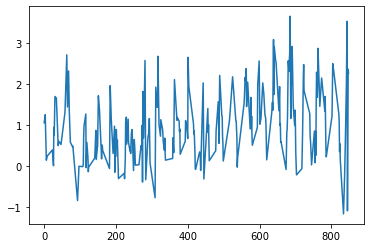

In [217]:
parameters_df[parameters_df['day_x0'] > 0.7*City_bound_xmax].method_2_SUHI.plot()

In [233]:
#Quality check
#if parameter a0 is 
#Number of images with parameter standard deviation higher than mean
print('a0:', len(parameters_df[(parameters_df['day_std_dev_a0'] / parameters_df['day_a0']) > 1].index))

print('x0:', len(parameters_df[(parameters_df['day_std_dev_x0'] / parameters_df['day_x0']) > 1].index))

print('y0:', len(parameters_df[(parameters_df['day_std_dev_y0'] / parameters_df['day_y0']) > 1].index))

print('phi:', len(parameters_df[(parameters_df['day_std_dev_phi'] / parameters_df['day_phi']) > 1].index))

print('ax:', len(parameters_df[(parameters_df['day_std_dev_ax'] / parameters_df['day_ax']) > 1].index))

print('ay:', len(parameters_df[(parameters_df['day_std_dev_ay'] / parameters_df['day_ay']) > 1].index))


a0: 15
x0: 49
y0: 38
phi: 30
ax: 12
ay: 12


In [234]:
#Remove the values for which the std deviation shows the fit to not have worked- no SUHI exists
parameters_df_qu = parameters_df.copy()

parameters_df_qu.loc[(parameters_df_qu['day_std_dev_a0'] / parameters_df_qu['day_a0']) > 1, 'day_x0'] = np.nan

parameters_df_qu.loc[(parameters_df_qu['day_std_dev_a0'] / parameters_df_qu['day_a0']) > 1, 'day_y0'] = np.nan

parameters_df_qu.loc[(parameters_df_qu['day_std_dev_a0'] / parameters_df_qu['day_a0']) > 1, 'day_phi'] = np.nan

parameters_df_qu.loc[(parameters_df_qu['day_std_dev_a0'] / parameters_df_qu['day_a0']) > 1, 'day_ax'] = np.nan

parameters_df_qu.loc[(parameters_df_qu['day_std_dev_a0'] / parameters_df_qu['day_a0']) > 1, 'day_ay'] = np.nan
#have to run this one last as it is used to update the others
parameters_df_qu.loc[(parameters_df_qu['day_std_dev_a0'] / parameters_df_qu['day_a0']) > 1, 'day_a0'] = np.nan


#remove based on ax
parameters_df_qu.loc[(parameters_df_qu['day_std_dev_ax'] / parameters_df_qu['day_ax']) > 1, 'day_a0'] = np.nan

parameters_df_qu.loc[(parameters_df_qu['day_std_dev_ax'] / parameters_df_qu['day_ax']) > 1, 'day_x0'] = np.nan

parameters_df_qu.loc[(parameters_df_qu['day_std_dev_ax'] / parameters_df_qu['day_ax']) > 1, 'day_y0'] = np.nan

parameters_df_qu.loc[(parameters_df_qu['day_std_dev_ax'] / parameters_df_qu['day_ax']) > 1, 'day_phi'] = np.nan

parameters_df_qu.loc[(parameters_df_qu['day_std_dev_ax'] / parameters_df_qu['day_ax']) > 1, 'day_ay'] = np.nan
#have to run this one last as it is used to update the others
parameters_df_qu.loc[(parameters_df_qu['day_std_dev_ax'] / parameters_df_qu['day_ax']) > 1, 'day_ax'] = np.nan

#remove based on ay
parameters_df_qu.loc[(parameters_df_qu['day_std_dev_ay'] / parameters_df_qu['day_ay']) > 1, 'day_a0'] = np.nan

parameters_df_qu.loc[(parameters_df_qu['day_std_dev_ay'] / parameters_df_qu['day_ay']) > 1, 'day_x0'] = np.nan

parameters_df_qu.loc[(parameters_df_qu['day_std_dev_ay'] / parameters_df_qu['day_ay']) > 1, 'day_y0'] = np.nan

parameters_df_qu.loc[(parameters_df_qu['day_std_dev_ay'] / parameters_df_qu['day_ay']) > 1, 'day_phi'] = np.nan

parameters_df_qu.loc[(parameters_df_qu['day_std_dev_ay'] / parameters_df_qu['day_ay']) > 1, 'day_ax'] = np.nan
#have to run this one last as it is used to update the others
parameters_df_qu.loc[(parameters_df_qu['day_std_dev_ay'] / parameters_df_qu['day_ay']) > 1, 'day_ay'] = np.nan

#remove based on x0
parameters_df_qu.loc[(parameters_df_qu['day_std_dev_x0'] / parameters_df_qu['day_x0']) > 1, 'day_a0'] = np.nan
parameters_df_qu.loc[(parameters_df_qu['day_std_dev_x0'] / parameters_df_qu['day_x0']) > 1, 'day_y0'] = np.nan
parameters_df_qu.loc[(parameters_df_qu['day_std_dev_x0'] / parameters_df_qu['day_x0']) > 1, 'day_phi'] = np.nan
parameters_df_qu.loc[(parameters_df_qu['day_std_dev_x0'] / parameters_df_qu['day_x0']) > 1, 'day_ax'] = np.nan
parameters_df_qu.loc[(parameters_df_qu['day_std_dev_x0'] / parameters_df_qu['day_x0']) > 1, 'day_ay'] = np.nan
#have to run this one last as it is used to update the others
parameters_df_qu.loc[(parameters_df_qu['day_std_dev_x0'] / parameters_df_qu['day_x0']) > 1, 'day_x0'] = np.nan

#remove based on y0
parameters_df_qu.loc[(parameters_df_qu['day_std_dev_y0'] / parameters_df_qu['day_y0']) > 1, 'day_a0'] = np.nan
parameters_df_qu.loc[(parameters_df_qu['day_std_dev_y0'] / parameters_df_qu['day_y0']) > 1, 'day_x0'] = np.nan
parameters_df_qu.loc[(parameters_df_qu['day_std_dev_y0'] / parameters_df_qu['day_y0']) > 1, 'day_ay'] = np.nan
parameters_df_qu.loc[(parameters_df_qu['day_std_dev_y0'] / parameters_df_qu['day_y0']) > 1, 'day_phi'] = np.nan
parameters_df_qu.loc[(parameters_df_qu['day_std_dev_y0'] / parameters_df_qu['day_y0']) > 1, 'day_ax'] = np.nan
#have to run this one last as it is used to update the others
parameters_df_qu.loc[(parameters_df_qu['day_std_dev_y0'] / parameters_df_qu['day_y0']) > 1, 'day_y0'] = np.nan



In [235]:
print('a0:', len(parameters_df_qu[(parameters_df_qu['day_std_dev_a0'] / parameters_df_qu['day_a0']) > 1].index))

print('x0:', len(parameters_df_qu[(parameters_df_qu['day_std_dev_x0'] / parameters_df_qu['day_x0']) > 1].index))

print('y0:', len(parameters_df_qu[(parameters_df_qu['day_std_dev_y0'] / parameters_df_qu['day_y0']) > 1].index))

print('phi:', len(parameters_df_qu[(parameters_df_qu['day_std_dev_phi'] / parameters_df_qu['day_phi']) > 1].index))

print('ax:', len(parameters_df_qu[(parameters_df_qu['day_std_dev_ax'] / parameters_df_qu['day_ax']) > 1].index))

print('ay:', len(parameters_df_qu[(parameters_df_qu['day_std_dev_ay'] / parameters_df_qu['day_ay']) > 1].index))

a0: 0
x0: 0
y0: 0
phi: 18
ax: 0
ay: 0


In [251]:
parameters_df_qu[(parameters_df_qu['day_ax'] > 15)]

parameters_df_qu[(parameters_df_qu['day_x0'] > 15)]

,Filename,Date,Year,Month,day_a0,day_x0,day_y0,day_phi,day_ax,day_ay,day_std_dev_a0,day_std_dev_x0,day_std_dev_y0,day_std_dev_phi,day_std_dev_ax,day_std_dev_ay,method_1_SUHI,method_2_SUHI
3,MOD11A2.A2000105.h19v10.006.2015059130754.hdf,14/04/2000,2000.0,4.0,1.355677,5.575594,-1.305262,11.793478,20.000000,8.058729,0.103120,0.770016,0.335029,3.022220,1.704962,0.604165,1.252468,1.248438
5,MOD11A2.A2000121.h19v10.006.2015060121736.hdf,30/04/2000,2000.0,4.0,1.496643,-4.000000,1.081384,-18.028325,20.000000,2.571812,0.201245,1.292102,0.450220,1.434571,2.877286,0.342081,0.586260,0.582016
8,MOD11A2.A2000145.h19v10.006.2015062021131.hdf,24/05/2000,2000.0,5.0,1.706645,1.291917,-3.408309,-173.110346,20.000000,10.898766,0.107841,0.630197,0.346680,3.976463,1.334952,0.681854,0.804984,0.795976
11,MOD11A2.A2000169.h19v10.006.2015063133124.hdf,17/06/2000,2000.0,6.0,2.045821,5.600000,-4.000000,34.341486,20.000000,7.098376,0.162639,0.680221,0.505349,2.644974,1.675233,0.560065,-0.474094,-0.488426
12,MOD11A2.A2000177.h19v10.006.2015064014458.hdf,25/06/2000,2000.0,6.0,1.553937,5.600000,-3.999986,32.849857,19.999978,7.543748,0.155686,0.873980,0.629140,3.616839,2.121244,0.749777,-0.213278,-0.221685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
840,MOD11A2.A2020289.h19v10.006.2020301150701.hdf,15/10/2020,2020.0,10.0,2.206327,4.132385,1.480907,105.063575,19.999687,9.417061,0.195481,0.461360,0.862733,4.349322,1.838484,0.830520,2.548021,2.528377
843,MOD11A2.A2020313.h19v10.006.2020322033545.hdf,08/11/2020,2020.0,11.0,5.307672,-3.765857,2.700363,-168.099543,17.795579,8.737885,0.251841,0.412486,0.217844,2.478272,0.870553,0.409160,4.041358,3.967071
844,MOD11A2.A2020329.h19v10.006.2020338105328.hdf,24/11/2020,2020.0,11.0,3.593041,5.027617,1.063108,1.194446,20.000000,4.587685,0.214710,0.617768,0.135596,1.192752,1.339902,0.270205,3.553444,3.521570
846,MOD11A2.A2020345.h19v10.006.2020358214739.hdf,10/12/2020,2020.0,12.0,5.513313,5.600000,4.000000,-77.995281,20.000000,6.104042,0.405389,0.266030,0.726486,2.017319,1.567581,0.444109,0.407722,0.394088


<AxesSubplot:>

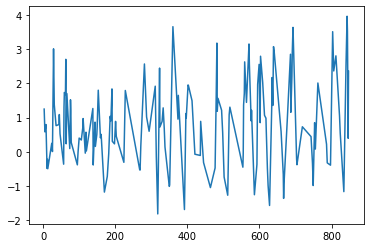

In [252]:
parameters_df[(parameters_df_qu['day_ax'] > 15)].method_2_SUHI.plot()

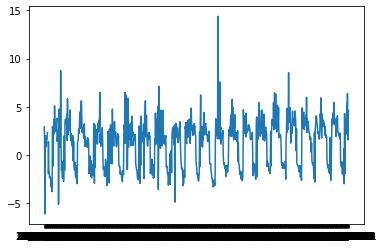

In [105]:
y_vals = parameters_df.day_a0
x_vals = parameters_df.Date

plt.plot(x_vals, y_vals)

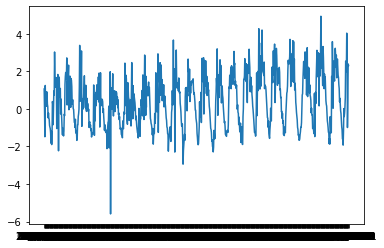

In [108]:
y_vals = parameters_df.method_1_SUHI
x_vals = parameters_df.Date

plt.plot(x_vals, y_vals)

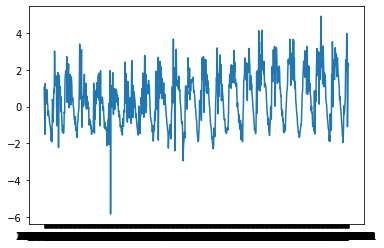

In [109]:
y_vals = parameters_df.method_2_SUHI
x_vals = parameters_df.Date

plt.plot(x_vals, y_vals)

In [180]:
a0 = parameters_df[parameters_df['Filename'] == choose_file]['day_a0'].values[0]

In [186]:
#function to open the file and get temps into required format
def image_gen(choose_file):
    df_subset = dataframe_create(choose_file)
    yeardoy = file_name.split('.')[1][1:]                               # Split filename to retrieve acquisition date
    date = dt.datetime.strptime(yeardoy, '%Y%j').strftime('%d/%m/%Y') 
    year = dt.datetime.strptime(yeardoy, '%Y%j').strftime('%Y') 
    month = dt.datetime.strptime(yeardoy, '%Y%j').strftime('%m') 

    #add in the x y coords
    df_subset['x_points'] = x_points
    df_subset['y_points'] = y_points

    #add a translated QC flag (where 0 is usuable, 1 not usable) 
    #apply QC function to dataframe (function checks that the first 2 bytes of the QC flag are 0, which means its good quality)
    QC_day2 = np.array([quality_control(int(i)) for i in df_subset.QC_day])
    #QC_night2 = np.array([quality_control(int(i)) for i in df_subset.QC_night])

    #add this QC2 flag onto the dataset
    df_subset['QC_day2'] = QC_day2
    #df_subset['QC_night2'] = QC_night2

    #add in the urban classification
    #there isn't LULC info for after 2015 so use 2015 for dates after this
    if year in ('2016', '2017', '2018', '2019', '2020', '2021'):
        year2 = '2015'
    else:
        year2 = year
        
    df_subset['is_urban'] = LULC_df['is_urban_overall_{}'.format(year2)].values
    
    #outside of city area and urban
    df_drop = df_subset[((df_subset['x_points'] < City_bound_xmin) | (df_subset['x_points'] > City_bound_xmax) 
                             | (df_subset['y_points'] < City_bound_ymin) | (df_subset['y_points'] > City_bound_ymax)
              ) & (df_subset['is_urban'] == 1)]

    #remove the areas which are urban but outside the city from the analysis
    df_subset = df_subset.drop(df_drop.index)
    
    #the urban classification and QC2 flag used to apply mask to the urban areas and the areas with QC2 flag = 1
    #remove the pixels which are not of good quality from the dataset
    #Separates into daytime good quality pixels and nightime good quality pixels 
    df_day_gq = df_subset[df_subset['QC_day2'] == 0].copy()
    
    df_rural_day = df_day_gq[df_day_gq['is_urban'] == 0][['LST_day','x_points', 'y_points']].copy()
    
    #will then apply a mulitple linear regression (with 2 variables, x and y) to this subset to get something of the form
    # LST = T0 + (a1)x + (a2)y
    #T0, a1, a2 coefficients to be determined

    #Perform regression
    #Divide the data into attributes and labels
    #rural daytime
    X = df_rural_day[['x_points','y_points']].values
    y = df_rural_day['LST_day'].values

    #Fit the model to the training set
    regressor = LinearRegression()
    regressor.fit(X, y)

    #Use the regression to predict T_0
    #This will give a baseline for what the temperature would be in the urban area if it was rural

    #create the column T_0 with the predicted rural baseline temperatures
    pred_input = df_day_gq[['x_points','y_points']].values
    df_day_gq['T_0_pred'] = regressor.predict(pred_input)

    #Take the predicted baseline temperature away from the LST to get the SUHI footprint 
    df_day_gq['SUHI'] = df_day_gq['LST_day'] - df_day_gq['T_0_pred']
   
    return df_day_gq

In [253]:
#Plot the parameters on the heat map
choose_file = 'MOD11A2.A2020353.h19v10.006.2020364220557.hdf'

a0 = parameters_df[parameters_df['Filename'] == choose_file]['day_a0'].values[0]
phi = parameters_df[parameters_df['Filename'] == choose_file]['day_phi'].values[0]

sphi2 = (np.sin(phi))**2
cphi2 = (np.cos(phi))**2
a_x = parameters_df[parameters_df['Filename'] == choose_file]['day_ax'].values[0]
a_y = parameters_df[parameters_df['Filename'] == choose_file]['day_ay'].values[0]
ax2 = a_x **2
ay2 = a_y **2
y0 = parameters_df[parameters_df['Filename'] == choose_file]['day_y0'].values[0]
x0 = parameters_df[parameters_df['Filename'] == choose_file]['day_x0'].values[0]

temp_df = image_gen(choose_file)

#Function calculates x and y for a given SUHI magnitude
def calc_xy(SUHI):
    yextent = np.sqrt(np.log(SUHI/a0)/(-sphi2/(0.5*ax2)-cphi2/(0.5*ay2))) # yextent is y - y0
    xextent = np.sqrt(np.log(SUHI/a0)/(-cphi2/(0.5*ax2)-sphi2/(0.5*ay2))) # xextent is x- x0
    return [xextent,yextent]

#calculating where the temperature falls within 61% of its maximum value
xextent_61 = np.sqrt(1/(4*(cphi2/ax2 + sphi2/ay2))) # xextent is x - x0 #SUHI/a0 = e**0.5
yextent_61 = np.sqrt(1/(4*(sphi2/ax2 + cphi2/ay2))) # yextent is y - y0 #SUHI/a0 = e**0.5


Text(0.5, 1.0, 'SUHI (K)')

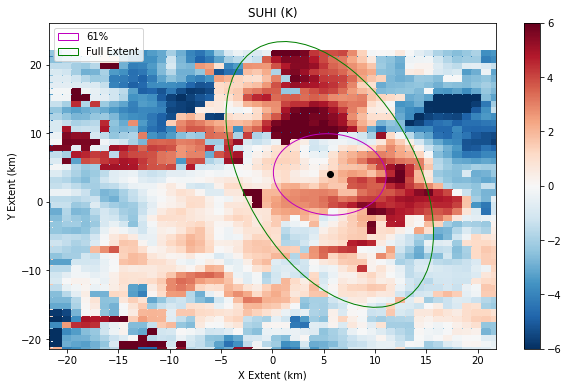

In [254]:
#Make plot
#Colour mesh plot
fig = plt.figure(figsize=(10, 6))
ax=plt.gca()

x_suhi = temp_df.x_points
y_suhi = temp_df.y_points
SUHI = temp_df.SUHI

#get the points into the correct format
X_suhi ,Y_suhi = np.meshgrid(x_suhi ,y_suhi)
Z_suhi = scipy.interpolate.griddata((x_suhi, y_suhi), SUHI, (X_suhi,Y_suhi), method='nearest')

c = ax.pcolormesh(X_suhi,Y_suhi, Z_suhi, cmap ='RdBu_r', vmin=-6, vmax=6)
fig.colorbar(c, ax=ax)

ax.plot(x0,y0,'ko') 

ellipse_outer = mpatches.Ellipse((x0,y0), 2*a_x, 2*a_y, angle=phi, fill=False, label = 'Full Extent', edgecolor = 'g')
ellipse = mpatches.Ellipse((x0,y0), 2*xextent_61, 2*yextent_61, angle=phi, fill=False, label = '61%', edgecolor = 'm')
ax.add_patch(ellipse)
ax.add_patch(ellipse_outer)
ax.legend()

plt.xlabel('X Extent (km)')
plt.ylabel('Y Extent (km)')
plt.title('SUHI (K)')

In [150]:
#Plot the parameters on the heat map

#Looking at where the boundarys of different temperatures for the SUHI
#function to convert the angle into degrees and between -180 and 180
def rad_to_deg(angle):
    deg = math.degrees(angle)
    if (deg % 360) > 180:
        deg = (deg % 360) - 360
    return deg

#NIGHTTIME
popt = night_popt

#SUHI = 1
a0 = popt[0]
phi = popt[3]
phi_deg = rad_to_deg(phi)
sphi2 = (np.sin(phi))**2
cphi2 = (np.cos(phi))**2
a_x = popt[4]
a_y = popt[5]
ax2 = popt[4]**2
ay2 = popt[5]**2
y0 = popt[2]
x0 = popt[1]

#Function calculates x and y for a given SUHI magnitude
def calc_xy(SUHI):
    yextent = np.sqrt(np.log(SUHI/a0)/(-sphi2/(0.5*ax2)-cphi2/(0.5*ay2))) # yextent is y - y0
    xextent = np.sqrt(np.log(SUHI/a0)/(-cphi2/(0.5*ax2)-sphi2/(0.5*ay2))) # xextent is x- x0
    return [xextent,yextent]

#calculating where the temperature falls within 61% of its maximum value
xextent_61 = np.sqrt(1/(4*(cphi2/ax2 + sphi2/ay2))) # xextent is x - x0 #SUHI/a0 = e**0.5
yextent_61 = np.sqrt(1/(4*(sphi2/ax2 + cphi2/ay2))) # yextent is y - y0 #SUHI/a0 = e**0.5


Text(0.5, 1.0, 'SUHI (K)')

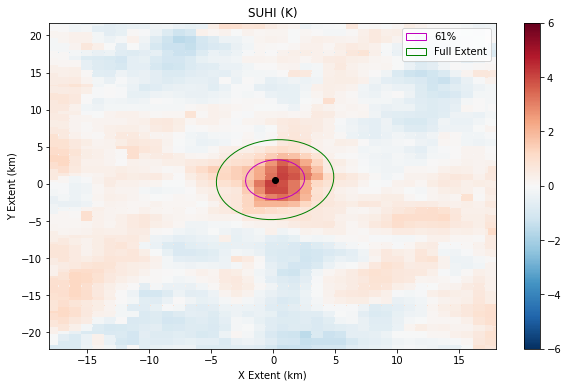

In [152]:
#Make plot
#Colour mesh plot
fig = plt.figure(figsize=(10, 6))
ax=plt.gca()

x_suhi = df_night_gq.x_points
y_suhi = df_night_gq.y_points
SUHI = df_night_gq.SUHI

#get the points into the correct format
X_suhi ,Y_suhi = np.meshgrid(x_suhi ,y_suhi)
Z_suhi = scipy.interpolate.griddata((x_suhi, y_suhi), SUHI, (X_suhi,Y_suhi), method='nearest')

c = ax.pcolormesh(X_suhi,Y_suhi, Z_suhi, cmap ='RdBu_r', vmin=-6, vmax=6)
fig.colorbar(c, ax=ax)

ax.plot(x0,y0,'ko') 

ellipse_outer = mpatches.Ellipse((x0,y0), 2*a_x, 2*a_y, angle=phi_deg, fill=False, label = 'Full Extent', edgecolor = 'g')
ellipse = mpatches.Ellipse((x0,y0), 2*xextent_61, 2*yextent_61, angle=phi_deg, fill=False, label = '61%', edgecolor = 'm')
ax.add_patch(ellipse)
ax.add_patch(ellipse_outer)
ax.legend()

plt.xlabel('X Extent (km)')
plt.ylabel('Y Extent (km)')
plt.title('SUHI (K)')

In [119]:
deg = 490


In [120]:
deg % 360

130